/var/folders/dx/32n9k8z17kj9bnq_p1531_740000gn/T/ipykernel_19804/902465951.py:54: RuntimeWarning: overflow encountered in ushort_scalars
  ypre = y[j + i * w] - img_re[j + i * w - 1]  # 计算预测误差
/var/folders/dx/32n9k8z17kj9bnq_p1531_740000gn/T/ipykernel_19804/902465951.py:66: RuntimeWarning: overflow encountered in ushort_scalars
  mse += (y[i*w+j]-img_re[i*w+j])*(y[i*w+j]-img_re[i*w+j]);


当量化因子为1时，重建图像的PSNR值为8.41555427228638
对应的SSIM值为0.3172021650044361
当量化因子为2时，重建图像的PSNR值为10.945825915582848
对应的SSIM值为0.4518255970185512
当量化因子为4时，重建图像的PSNR值为22.816165494865764
对应的SSIM值为0.7695211328491395
当量化因子为8时，重建图像的PSNR值为51.136495041659785
对应的SSIM值为0.9958156945293135


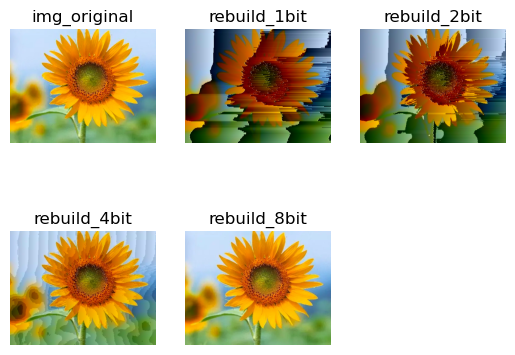

In [6]:
import math

#  姓名：王安文
#  学号：122106010768
#  作业名：DPCM编码的实现
#  课程：图像分析基础
#  作业实现内容：使用DPCM编码对灰度图片编码和解码，比较不同量化器（1，2，4，8bit）重建图像的区别
#             并计算重建图像的PSNR和SSIM值
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
# 传入要处理的图片 和 量化因子(1,2,4,8bit)
def dpcm_function(img, bit, grayimg):
    h, w = img.shape[:2]

    # 将 BGR 转换为 YCrCb ,将图片转换为 y,v,u分量。
    yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, v, u = cv2.split(yvu)

    # 下采样 U 和 V（应用 420 格式）。
    u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))
    v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))
    # 将 Y、U 和 V 写入“流”。之后就可以以字节的形式读取
    f = io.BytesIO()
    f.write(y.tobytes())
    f.write(u.tobytes())
    f.write(v.tobytes())
    f.seek(0)
    img_np = np.frombuffer(f.read(), np.uint8)
    img_yuv_len = img_np.size
    img_y_len = h * w

    y = img_np[:img_y_len]
    u = img_np[img_y_len:(img_yuv_len - img_y_len) // 2 + img_y_len]  # 要注意 w或h 为单数的情况
    v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]
    # DPCM量化编码，采用边编码，边解码的形式
    img_re = np.zeros(img_y_len, np.uint16)  # 用来存储重建图像,因为中间计算可能超过255，先用16，后面转回8
    yprebuff = np.zeros(img_y_len, np.uint16)  # 预测

    radio = 512 / (1 << bit)  # 量化因子bit
    for i in range(h):
        for j in range(w):
            if j == 0:
                # 每行第一个像素做一定变换预测
                ypre = y[j + i * w] - 128  # 计算预测误差
                yprebuff[j + i * w] = (ypre + 255) / radio  # 量化预测误差
                img_re[j + i * w] = (yprebuff[j + i * w] - 255 / radio) * radio + 128  # 重建像素,j解码
                if img_re[j + i * w] > 255:
                    img_re[j + i * w] = 255  # 防止重建像素超过255
                yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2
            else:
                ypre = y[j + i * w] - img_re[j + i * w - 1]  # 计算预测误差
                yprebuff[j + i * w] = (ypre + 255) / radio  # 量化  # 量化器
                img_re[j + i * w] = (yprebuff[j + i * w] - 255 / radio) * radio + img_re[j + i * w - 1]  # 反量化
                yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
                if img_re[j + i * w] > 255:
                    img_re[j + i * w] = 255  # 防止重建电平超过255
    # 计算重建图像的PSNR和SSIM值
    # PSNR = 10*lg(MAX^2/MSE)
    max = 255
    mse = 0.0  # 均方误差mse
    for i in range(h):
        for j in range(w):
            mse += (y[i*w+j]-img_re[i*w+j])*(y[i*w+j]-img_re[i*w+j]);
    mse = mse/(w*h)
    psnr = 10*math.log10(max*max/mse)
    print("当量化因子为"+str(bit)+"时，重建图像的PSNR值为"+str(psnr))

    img_re = img_re.astype(np.uint8)  # 用来存储重建图像,后面转回uint8
    yprebuff = yprebuff.astype(np.uint8)  # 预测误差

    # 重建图片
    img_re = img_re.reshape((h, w))  # 重建的y分量

    # 计算SSIM(X,Y) = L(X,Y)*C(X,Y)*S(X,Y) 有skimage库可以直接调用
    ssim = compare_ssim(grayimg,img_re,data_range=255)
    print("对应的SSIM值为"+str(ssim))
    u = u.reshape((h // 2, w // 2))  # 恢复采样后的u分量
    v = v.reshape((h // 2, w // 2))
    ru = cv2.resize(u, (w, h))  # 恢复采样前的u分量，用这个u分量来重建图片文件
    rv = cv2.resize(v, (w, h))

    yvu_re = cv2.merge((img_re, rv, ru))
    bgr_re = cv2.cvtColor(yvu_re, cv2.COLOR_YCrCb2BGR)  # 将解码后的的y,u,v分量转换回原图
    img_re = cv2.cvtColor(bgr_re, cv2.COLOR_BGR2RGB)




    return img_re   # 返回重建图
if __name__ == "__main__":
    img_in = cv2.imread('flower.jpg')
    img_gray = cv2.imread('flower.jpg',cv2.IMREAD_GRAYSCALE)
    img_new = img_in[:, :, ::-1]  # 将BGR翻转到RGB以提供给plt函数显示图像

    # 分别采用量化因子为1，2，4，8对原图像进行编码和解码
    img_rebuild1 = dpcm_function(img_in, 1, img_gray)
    img_rebuild2 = dpcm_function(img_in, 2, img_gray)
    img_rebuild4 = dpcm_function(img_in, 4, img_gray)
    img_rebuild8 = dpcm_function(img_in, 8, img_gray)

    # 显示结果 原图像和不同量化因子下重建后的图像
    plt.subplot(231), plt.imshow(img_new)
    plt.title('img_original'), plt.axis('off')
    plt.subplot(232), plt.imshow(img_rebuild1, cmap='gray'),
    plt.title('rebuild_1bit'), plt.axis('off')
    plt.subplot(233), plt.imshow(img_rebuild2, cmap='gray'),
    plt.title('rebuild_2bit'), plt.axis('off')
    plt.subplot(234), plt.imshow(img_rebuild4, cmap='gray'),
    plt.title('rebuild_4bit'), plt.axis('off')
    plt.subplot(235), plt.imshow(img_rebuild8, cmap='gray'),
    plt.title('rebuild_8bit'), plt.axis('off')
    plt.show()











